In [46]:
import numpy as np
import matplotlib.pyplot as plt

from aeon.utils.numba.general import z_normalise_series_2d

# from aeon.distances import euclidean_distance
# from aeon.distances import dtw_distance
from aeon.distances import get_distance_function

In [47]:
%load_ext autoreload
%autoreload 2

from ksfdtw.distance_measures import psdtw_prime
from ksfdtw.utils import precision_at_k

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# A neat way to load the dataset, but more complicated to use
# data = np.load("../data_intermediate/GunPoint_preprocessed_P_3_l_2.0_len_150.npz")
# data_dict = {key: data[key] for key in data.files}

# A old way to load the dataset
data = np.load(
    "../data_intermediate/GunPoint_preprocessed_P_3_l_2.0_len_150.npz",
    allow_pickle=True,
)
X_train_scaled = data["X_train_scaled"]
X_train_proc = data["X_train_proc"]
X_train_proc_noise = data["X_train_proc_noise"]
y_train = data["y_train"]
X_test_scaled = data["X_test_scaled"]
X_test_proc = data["X_test_proc"]
X_test_proc_noisy = data["X_test_proc_noise"]
y_test = data["y_test"]
train_cutting_orig = data["train_cutting_orig"].tolist()
train_cutting_final = data["train_cutting_final"].tolist()
test_cutting_orig = data["test_cutting_orig"].tolist()
test_cutting_final = data["test_cutting_final"].tolist()

In [49]:
X_train_scaled.shape, X_train_proc.shape, X_train_proc_noise.shape

((50, 150), (50, 150), (50, 150))

In [50]:
# X_train_scaled = X_train_scaled.squeeze()
X_train_scaled = X_train_scaled

In [51]:
X_train_scaled.shape

(50, 150)

In [52]:
X_train_scaled_norm = z_normalise_series_2d(X_train_scaled)
X_train_proc_norm = z_normalise_series_2d(X_train_proc)
X_train_proc_noise_norm = z_normalise_series_2d(X_train_proc_noise)

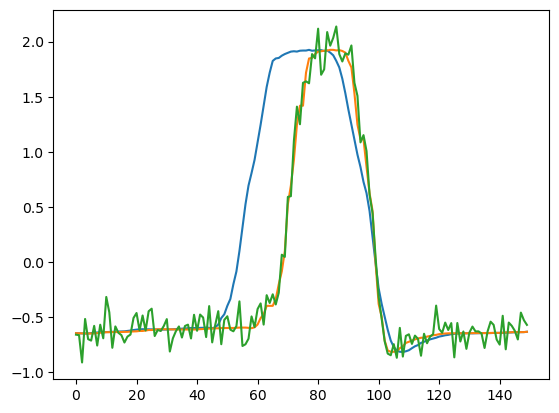

In [53]:
plt.plot(X_train_scaled[1])
plt.plot(X_train_proc[1])
plt.plot(X_train_proc_noise[1])

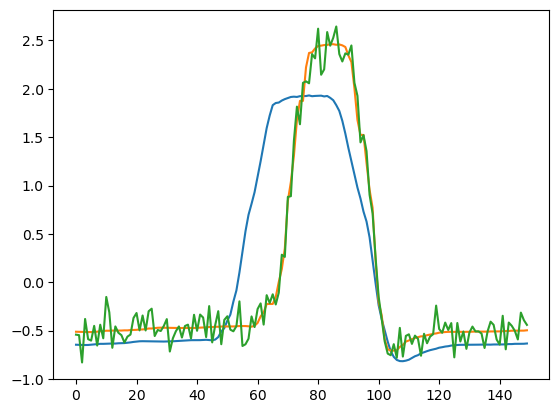

In [54]:
plt.plot(X_train_scaled_norm[1])
plt.plot(X_train_proc_norm[1])
plt.plot(X_train_proc_noise_norm[1])

In [55]:
# query_set = X_train_proc_noise_norm
query_set = X_train_proc_noise_norm
# target_set = X_train_scaled
target_set = X_train_scaled_norm
if len(query_set) != len(target_set):
    raise ValueError("query_set and target_set have different sizes!")

In [56]:
# Q = query_set[0]
# C = target_set[0]
# psdtw_prime(Q, C, l=2, P=3, r=0.1)

# Precision@k

Compute $P@k$ for querying $Q \in$ `query_set` using `method_name` on `target_set`

In [ ]:
# https://www.aeon-toolkit.org/en/stable/api_reference/auto_generated/aeon.distances.get_distance_function.html
# **aeon**
# *dtw*
# dist_func_prime = get_distance_function("dtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *shape_dtw*
# dist_func_prime = get_distance_function("shape_dtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *ddtw*
# dist_func_prime = get_distance_function("ddtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *wdtw*
# dist_func_prime = get_distance_function("wdtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *wddtw*
# dist_func_prime = get_distance_function("wddtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *adtw*
# dist_func_prime = get_distance_function("adtw")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *erp*
# dist_func_prime = get_distance_function("erp")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *edr*
# dist_func_prime = get_distance_function("edr")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *msm*
# dist_func_prime = get_distance_function("msm")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *twe*
# dist_func_prime = get_distance_function("twe")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *lcss*
# dist_func_prime = get_distance_function("lcss")
# dist_func = lambda Q, C: dist_func_prime(Q, C, window=0.1)

# *euclidean*
# dist_func = get_distance_function("euclidean")

# *manhattan*
# dist_func = get_distance_function("manhattan")

# *minkowski*
# dist_func = get_distance_function("minkowski")

# *sbd*
# dist_func = get_distance_function("sbd")

In [58]:
# **ksfdtw**
# *psdtw*
# dist_func = lambda Q, C: psdtw_prime(Q, C, l=2, P=3, r=0.1)

In [59]:
precision_at_1, precision_at_3, precision_at_5, precision_at_7 = 0, 0, 0, 0
for i in range(0, len(query_set)):
    distances = np.array([dist_func(query_set[i], x) for x in target_set])
    precision_at_1 += precision_at_k(distances, i, 1)
    precision_at_3 += precision_at_k(distances, i, 3)
    precision_at_5 += precision_at_k(distances, i, 5)
    precision_at_7 += precision_at_k(distances, i, 7)
# print(precision_at_1, precision_at_3, precision_at_5, precision_at_7)
print(
    f"{precision_at_1 / len(query_set):.2f},",
    f"{precision_at_3 / len(query_set):.2f},",
    f"{precision_at_5 / len(query_set):.2f},",
    f"{precision_at_7 / len(query_set):.2f}",
)

0.18, 0.32, 0.52, 0.60


In [60]:
###
###
###

# Results
target_set = X_train_proc
```
euclidean 0.18 0.38 0.52 0.6
dtw 0.24 0.4 0.56 0.64
adtw 0.2 0.34 0.48 0.64
ddtw 0.2 0.42 0.52 0.58
shape_dtw 0.22 0.26 0.38 0.56
wddtw 0.2 0.42 0.54 0.62
wdtw 0.24 0.4 0.58 0.64
```
target_set = X_train_proc_noise
```
euclidean 0.16 0.34 0.54 0.56
dtw 0.24 0.44 0.5 0.6
adtw 0.18 0.34 0.52 0.66
ddtw 0.24 0.38 0.46 0.5
shape_dtw 0.22 0.32 0.44 0.58
wddtw 0.26 0.42 0.48 0.56
wdtw 0.22 0.44 0.5 0.64
```